In [7]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from scmcallib import PointEstimateFinder, ParameterSet
from scmdata import df_append, ScmDataFrame
from scmcallib.distributions import Normal, Bound
from scmcallib.scm import AR5IR

In [34]:
def load_iam_timeseries(fname):
    # Read in the data. It requires a bit of wrangling to get it in the IamDataFrame format
    df = pd.read_csv(fname, header=None)
    df = df.set_index(0).T
    df.pop("time")
    df = ScmDataFrame(df).filter(region='World') # We only care about the 'World' region

    # Resample to annual means
    df = df.resample("AS")
    df['time'] = df['year']
    return df

# We are trying train the model to be able to emulate RCP8.5 output (incl. historical)
hist_df = load_iam_timeseries("../tests/test_data/netcdf-scm_tas_Amon_ACCESS1-0_historical_r1i1p1_185001-200512.csv")
hist_df["scenario"] = "cmip5_rcp85_r1i1p1"
scen_df = load_iam_timeseries("../tests/test_data/netcdf-scm_tas_Amon_ACCESS1-0_rcp85_r1i1p1_200601-210012.csv")

scen_df = df_append([hist_df, scen_df])
scen_df["variable"] = "Surface Temperature"
scen_df.head()

`parameter_type` metadata not available. Guessing parameter types where unavailable.
Duplicate time points detected, the output will be the average of the duplicates. Set `dulicate_msg='return'` to examine the joint timeseries (the duplicates can be found by looking at `res[res.index.duplicated(keep=False)].sort_index()`. Set `duplicate_msg=False` to silence this message.


time                                                                           1850-01-01  1851-01-01  1852-01-01  1853-01-01  ...  2098-01-01  2099-01-01  2100-01-01  2101-01-01
model     scenario           region variable            unit   parameter_type                                                  ...                                                
ACCESS1-0 cmip5_rcp85_r1i1p1 World  Surface Temperature kelvin point             284.9037  284.768881  284.926716  285.072473  ...  290.544203  290.340393  290.446153   290.64786

[1 rows x 252 columns]

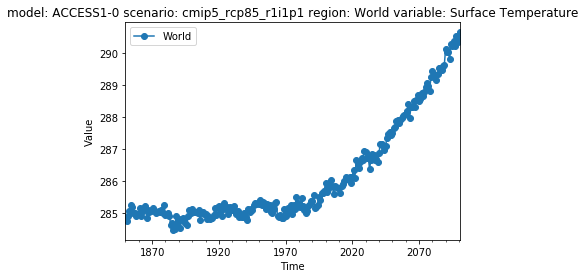

In [35]:
scen_df.line_plot(marker='region')

In [36]:
best_guess_c1 = 0.631
best_guess_c2 = 1
best_guess_a1 = 0.2240

param_set = ParameterSet()
param_set.set_tune('c1', Bound(Normal(mu=best_guess_c1, sd=1.), lower=0.1))
param_set.set_tune('c2', Bound(Normal(mu=best_guess_c2, sd=0.1), lower=0.1))
param_set.set_tune('a1', Bound(Normal(mu=best_guess_a1, sd=0.1), lower=0.0, upper=0.4))

scm = AR5IR()
scm.run({}).timeseries()

time                                               1765-01-01  1766-01-01  1767-01-01  1768-01-01  1769-01-01  1770-01-01  1771-01-01  1772-01-01  ...  2092-01-01  2093-01-01  2094-01-01  2095-01-01  2096-01-01  2097-01-01  2098-01-01  2099-01-01
model scenario    region variable            unit                                                                                                  ...                                                                                                
ar5ir unspecified World  Surface Temperature K            0.0         0.0    0.000001    0.000004    0.000007    0.000011    0.000015     0.00002  ...    2.608537    2.636388     2.66407    2.691574    2.718891    2.746015    2.772944    2.799674

[1 rows x 335 columns]

In [37]:
finder = PointEstimateFinder(param_set, reference_period=(2000, 2010))
finder.set_target(scen_df)

|   iter    |  target   |    a1     |    c1     |    c2     |
-------------------------------------------------------------
|  3        | -5.753    |  0.1781   |  3.274    |  0.2205   |
|  5        | -1.152    |  0.1468   |  2.138    |  0.3401   |
|  8        | -0.5518   |  0.1075   |  1.755    |  1.038    |
|  9        | -0.1037   |  0.1451   |  0.9547   |  1.14     |
|  10       | -0.04483  |  0.345    |  1.25     |  0.9333   |
|  52       | -0.0417   |  0.174    |  1.122    |  1.339    |
|  301      | -0.0411   |  0.000607 |  1.119    |  1.401    |


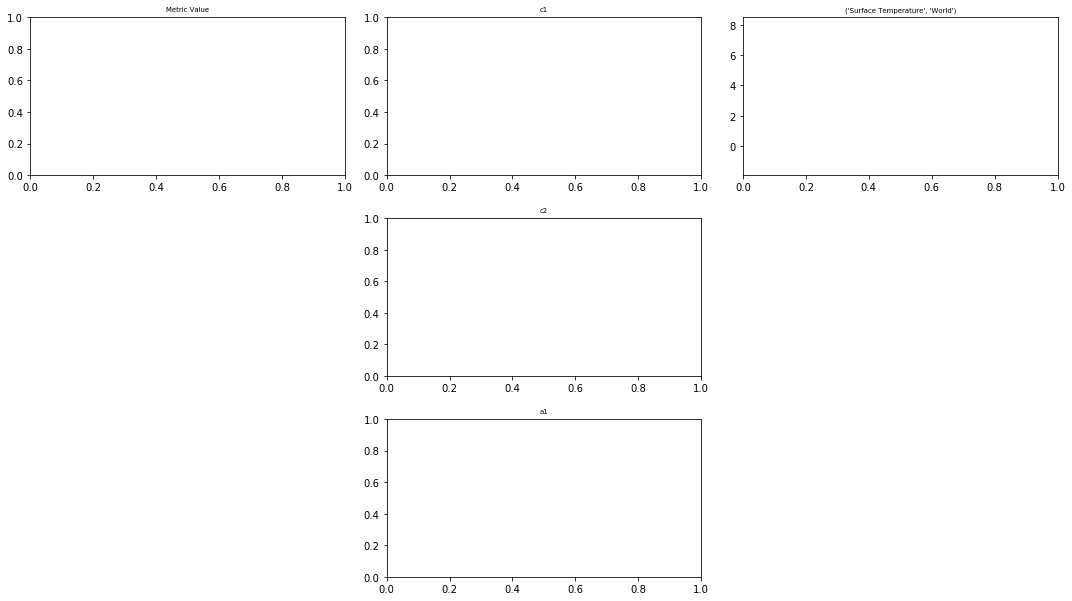

Log scale: values of z <= 0 have been masked
No contour levels were found within the data range.


IndexError: index 2 is out of bounds for axis 1 with size 2

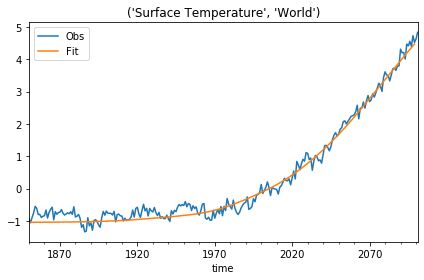

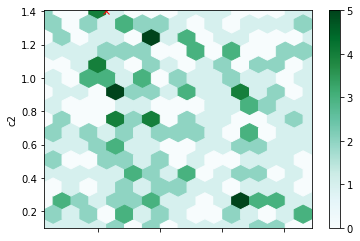

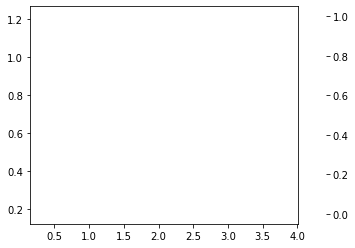

In [38]:
results = finder.find_best_fit(
    scm=scm,
    optimiser_name="bayesopt",
    init_points=300,
    n_iter=10,
    verbose=1)

results.print_summary()
results.plot_summary()
results.plot_fit()
results.plot_heatmap('c1', 'c2')
results.plot_likelihood_surface('c1', 'c2')

In [7]:
results.coeffs

{'a1': 0.10047502543914621, 'c1': 1.1133246868095035, 'c2': 1.4350666281264737}

      fun: 0.03249681796386167
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([2.94902991e-06, 4.01068068e-07, 7.06670833e-05])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 44
      nit: 5
   status: 0
  success: True
        x: {'c1': 0.6123395057161133, 'c2': 5.025909520420239, 'a1': 0.0}


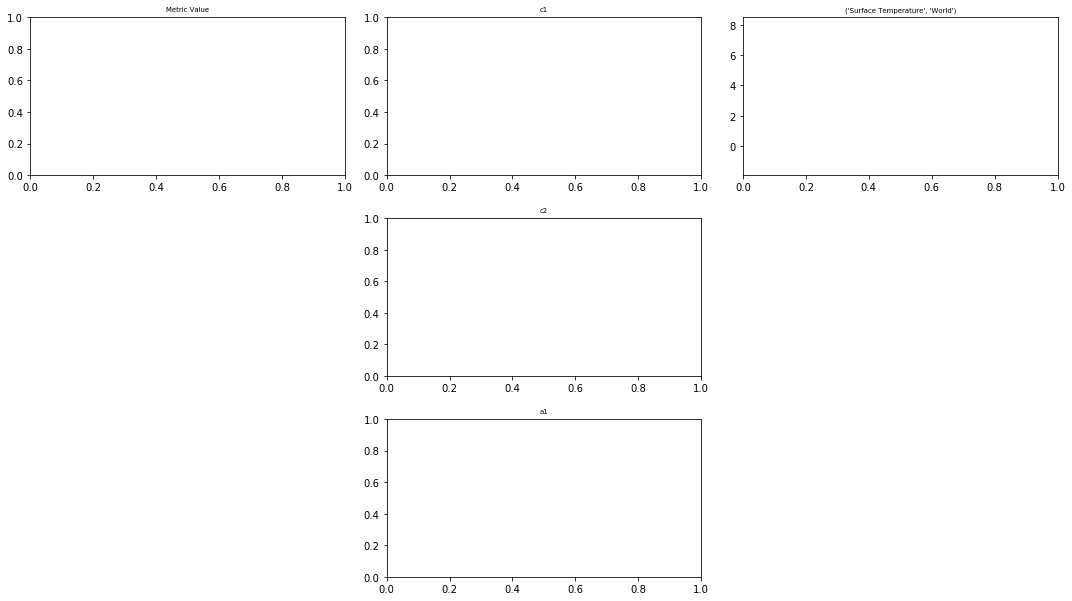

Log scale: values of z <= 0 have been masked
No contour levels were found within the data range.


IndexError: index 2 is out of bounds for axis 1 with size 2

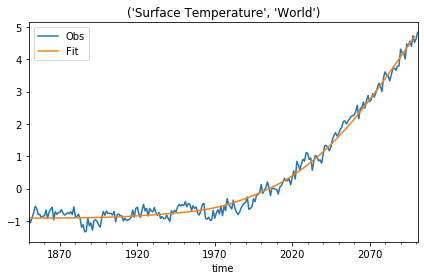

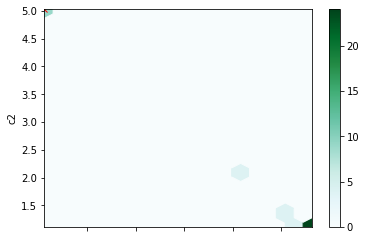

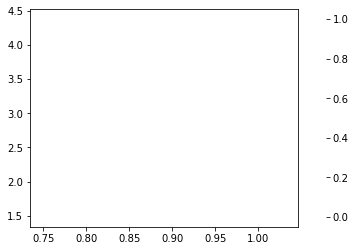

In [39]:
x0 = finder.find_x0(scm, samples=100)
results = finder.find_best_fit(
    scm,
    x0=x0,
    optimiser_name="scipy",
)

results.print_summary()
results.plot_summary()
results.plot_fit()
results.plot_heatmap('c1', 'c2')
results.plot_likelihood_surface('c1', 'c2')

In [ ]:
results.coeffs